---
#### Written by:

    Habiba Mowafy

---

This notebook is part of the Cellula Internship. The goal of this task is to analyze a dataset related to hotel bookings, perform data cleaning, handle outliers, prepare the data for further analysis or modeling and apply suitable models.

In [168]:
# Import important libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import zscore
import joblib

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, RocCurveDisplay, precision_score, recall_score, f1_score
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [169]:
# Read the data
data = pd.read_csv("first inten project.csv")

In [170]:
# Display the first 10 rows of the data
data.head()

,Booking_ID,number of adults,number of children,number of weekend nights,number of week nights,type of meal,car parking space,room type,lead time,market segment type,repeated,P-C,P-not-C,average price,special requests,date of reservation,booking status
0,INN00001,1,1,2,5,Meal Plan 1,0,Room_Type 1,224,Offline,0,0,0,88.00,0,10/2/2015,Not_Canceled
1,INN00002,1,0,1,3,Not Selected,0,Room_Type 1,5,Online,0,0,0,106.68,1,11/6/2018,Not_Canceled
2,INN00003,2,1,1,3,Meal Plan 1,0,Room_Type 1,1,Online,0,0,0,50.00,0,2/28/2018,Canceled
3,INN00004,1,0,0,2,Meal Plan 1,0,Room_Type 1,211,Online,0,0,0,100.00,1,5/20/2017,Canceled
4,INN00005,1,0,1,2,Not Selected,0,Room_Type 1,48,Online,0,0,0,77.00,0,4/11/2018,Canceled


In [171]:
# Display the columns in the data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36285 entries, 0 to 36284
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Booking_ID                36285 non-null  object 
 1   number of adults          36285 non-null  int64  
 2   number of children        36285 non-null  int64  
 3   number of weekend nights  36285 non-null  int64  
 4   number of week nights     36285 non-null  int64  
 5   type of meal              36285 non-null  object 
 6   car parking space         36285 non-null  int64  
 7   room type                 36285 non-null  object 
 8   lead time                 36285 non-null  int64  
 9   market segment type       36285 non-null  object 
 10  repeated                  36285 non-null  int64  
 11  P-C                       36285 non-null  int64  
 12  P-not-C                   36285 non-null  int64  
 13  average price             36285 non-null  float64
 14  specia

In [172]:
# Display data description
data.describe()

,number of adults,number of children,number of weekend nights,number of week nights,car parking space,lead time,repeated,P-C,P-not-C,average price,special requests
count,36285.000000,36285.000000,36285.000000,36285.000000,36285.000000,36285.000000,36285.000000,36285.000000,36285.000000,36285.000000,36285.000000
mean,1.844839,0.105360,0.810693,2.204602,0.030977,85.239851,0.025630,0.023343,0.153369,103.421636,0.619733
std,0.518813,0.402704,0.870590,1.410946,0.173258,85.938796,0.158032,0.368281,1.753931,35.086469,0.786262
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,0.000000,0.000000,1.000000,0.000000,17.000000,0.000000,0.000000,0.000000,80.300000,0.000000
50%,2.000000,0.000000,1.000000,2.000000,0.000000,57.000000,0.000000,0.000000,0.000000,99.450000,0.000000
75%,2.000000,0.000000,2.000000,3.000000,0.000000,126.000000,0.000000,0.000000,0.000000,120.000000,1.000000
max,4.000000,10.000000,7.000000,17.000000,1.000000,443.000000,1.000000,13.000000,58.000000,540.000000,5.000000


In [173]:
# Rename some columns
data.rename(columns={'repeated': 'regular customer',
                    'P-C': 'Previously Canceled reservations',
                    'P-not-C': 'Previously Not Canceled reservations',
                    'average price ': 'average price'},
            inplace=True, errors='raise')

In [174]:
# Check for missing values
data.isnull().sum()

Booking_ID                              0
number of adults                        0
number of children                      0
number of weekend nights                0
number of week nights                   0
type of meal                            0
car parking space                       0
room type                               0
lead time                               0
market segment type                     0
regular customer                        0
Previously Canceled reservations        0
Previously Not Canceled reservations    0
average price                           0
special requests                        0
date of reservation                     0
booking status                          0
dtype: int64

In [175]:
# Check how many unique values in each feature
data[['Booking_ID','type of meal', 'room type', 'market segment type']].nunique()

Booking_ID             36285
type of meal               4
room type                  7
market segment type        5
dtype: int64

In [176]:
# Define a function to check if the date is in the correct format
import re

def is_valid_date_format(date):
    if pd.isna(date):
        return False
    # Pattern for MM/D/YYYY or M/D/YYYY
    pattern = r'^\d{1,2}/\d{1,2}/\d{4}$'
    return bool(re.match(pattern, str(date)))

In [177]:
# Extract invalid dates
invalid_dates = data[~data['date of reservation'].apply(is_valid_date_format)]

print(f"Number of invalid dates: {len(invalid_dates)}")
print("\nExamples of invalid dates:")
print(invalid_dates['date of reservation'].head(20))

Number of invalid dates: 37

Examples of invalid dates:
2626     2018-2-29
3677     2018-2-29
5600     2018-2-29
6343     2018-2-29
7648     2018-2-29
8000     2018-2-29
8989     2018-2-29
9153     2018-2-29
9245     2018-2-29
9664     2018-2-29
9934     2018-2-29
10593    2018-2-29
10652    2018-2-29
10747    2018-2-29
11881    2018-2-29
13958    2018-2-29
14304    2018-2-29
15363    2018-2-29
15438    2018-2-29
17202    2018-2-29
Name: date of reservation, dtype: object


In [178]:
# Drop invalid dates
data = data[data['date of reservation'].apply(is_valid_date_format)]

# Verify the cleaning
print(f"\nNew dataset size: {len(data)}")


New dataset size: 36248


In [179]:
# Convert the date of reservation to datetime
data['date of reservation'] = pd.to_datetime(data['date of reservation'], errors='coerce')

In [180]:
# Recheck if there are missing values appeared after cleaning
data.isnull().sum()

Booking_ID                              0
number of adults                        0
number of children                      0
number of weekend nights                0
number of week nights                   0
type of meal                            0
car parking space                       0
room type                               0
lead time                               0
market segment type                     0
regular customer                        0
Previously Canceled reservations        0
Previously Not Canceled reservations    0
average price                           0
special requests                        0
date of reservation                     0
booking status                          0
dtype: int64

In [181]:
data['reservation_year'] = data['date of reservation'].dt.year.astype(int)
data['reservation_month'] = data['date of reservation'].dt.month.astype(int)
data.drop(columns=['date of reservation'], inplace=True)

In [182]:
# Discover the unique values of the columns
checked_columns = ['type of meal', 'room type', 'market segment type']
for column in checked_columns:
    print(column)
    print(data[column].unique())
    print("----------------")

type of meal
['Meal Plan 1' 'Not Selected' 'Meal Plan 2' 'Meal Plan 3']
----------------
room type
['Room_Type 1' 'Room_Type 4' 'Room_Type 2' 'Room_Type 6' 'Room_Type 5'
 'Room_Type 7' 'Room_Type 3']
----------------
market segment type
['Offline' 'Online' 'Corporate' 'Aviation' 'Complementary']
----------------


#### Handling Lead Time Outliers

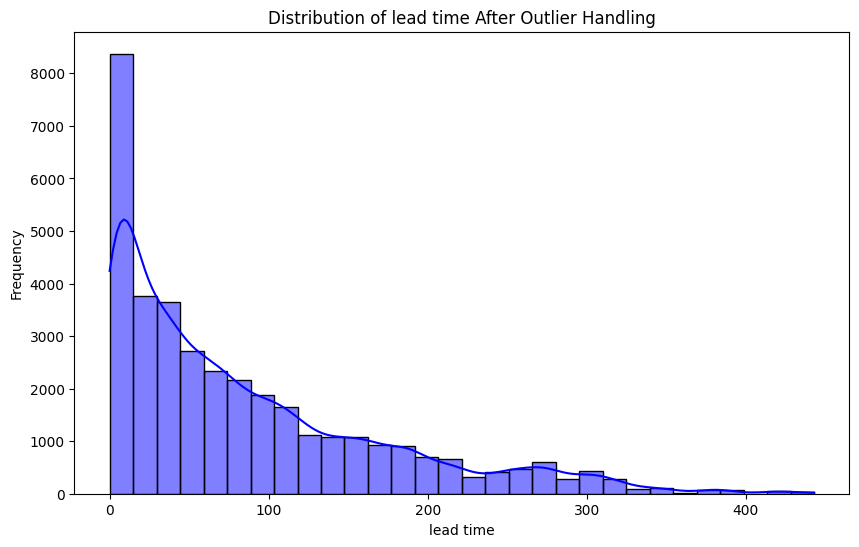

In [183]:
def plot_distribution(column):
    plt.figure(figsize=(10, 6))
    sns.histplot(data[column], kde=True, color='blue', bins=30)
    plt.title(f'Distribution of {column} After Outlier Handling')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.show()

# Plot distribution after handling outliers
plot_distribution('lead time')

In [184]:
original_skewness = data['lead time'].skew()

print(f'Original Skewness: {original_skewness}')

Original Skewness: 1.2916315950064692


In [185]:
# Calculate IQR for 'lead time'
Q1 = data['lead time'].quantile(0.25)  # First quartile (25th percentile)
Q3 = data['lead time'].quantile(0.75)  # Third quartile (75th percentile)
IQR = Q3 - Q1  # Interquartile range

# Define outlier bounds using IQR method
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

def is_iqr_outlier(value):
    return value < lower_bound or value > upper_bound

# Apply log transformation to outliers
data['lead time'] = data.apply(
    lambda row: np.log1p(row['lead time']) if is_iqr_outlier(row['lead time']) else row['lead time'], axis=1
)

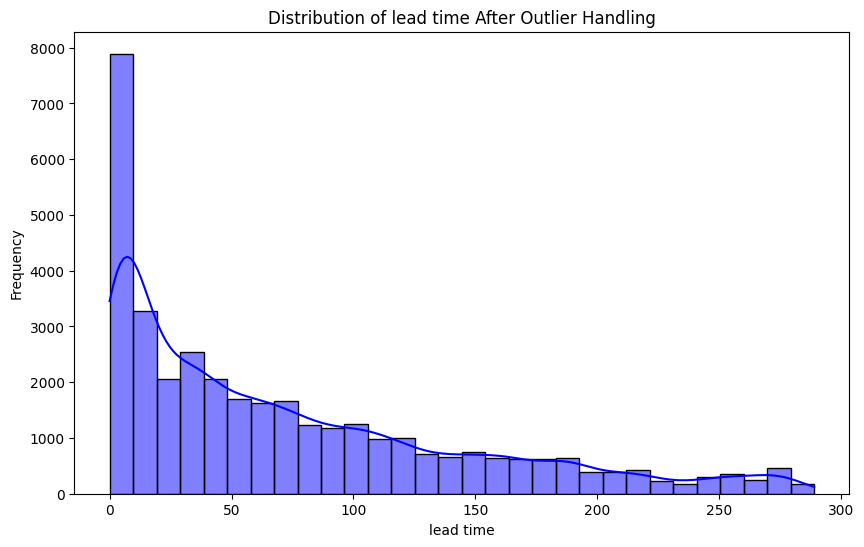

In [186]:
# Plot curves after handling outliers
plot_distribution('lead time')

In [187]:
# Check skewness of the original and transformed data
log_skewness = data['lead time'].skew()

print(f'Log Transformed Skewness: {log_skewness}')

Log Transformed Skewness: 1.0885590690190334


#### Handling Average Price Outliers

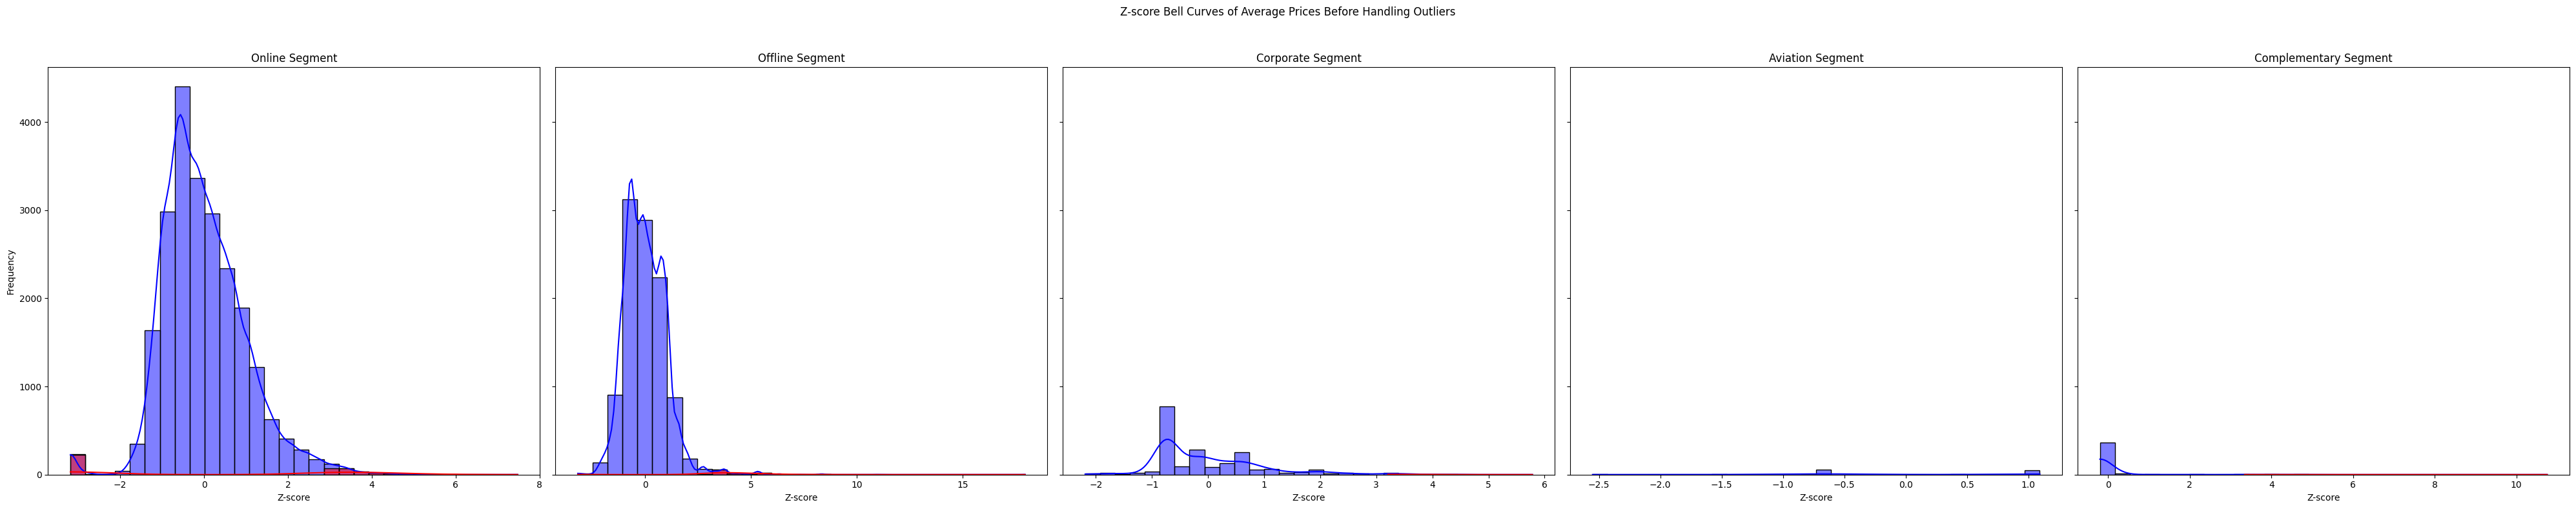

In [188]:
# Define the market segments
segments = ['Online', 'Offline', 'Corporate', 'Aviation', 'Complementary']

# Create subplots
fig, axes = plt.subplots(1, 5, figsize=(40, 8), sharey=True)

# Plot z-score bell curves for each segment before handling outliers
for i, segment in enumerate(segments):
    segment_data = data[data['market segment type'] == segment].copy()
    segment_data.loc[:, 'average_price_zscore'] = zscore(segment_data['average price'])

    sns.histplot(segment_data['average_price_zscore'], kde=True, color='blue', bins=30, ax=axes[i])

    # Highlight outliers
    outliers = segment_data[np.abs(segment_data['average_price_zscore']) > 3]
    sns.histplot(outliers['average_price_zscore'], kde=True, color='red', bins=30, ax=axes[i])

    axes[i].set_title(f'{segment} Segment')
    axes[i].set_xlabel('Z-score')
    axes[i].set_ylabel('Frequency')

plt.suptitle('Z-score Bell Curves of Average Prices Before Handling Outliers')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [189]:
def find_similar_bookings(row, segment_data, exclude_index):
    """
    Find similar bookings based on booking conditions
    Returns the mean price of similar bookings
    """
    # Define the features that make bookings similar
    similar_conditions = (
        (segment_data['number of adults'] == row['number of adults']) &
        (segment_data['number of children'] == row['number of children']) &
        (segment_data['number of weekend nights'] == row['number of weekend nights']) &
        (segment_data['number of week nights'] == row['number of week nights']) &
        (segment_data['room type'] == row['room type']) &
        (segment_data['type of meal'] == row['type of meal']) &
        (segment_data.index != exclude_index)  # Exclude the current booking
    )

    similar_bookings = segment_data[similar_conditions]

    # If we find similar bookings with non-zero prices, use their mean
    valid_prices = similar_bookings[similar_bookings['average price'] > 0]['average price']
    if len(valid_prices) > 0:
        return valid_prices.mean()

    # If no exact matches, relax conditions
    relaxed_conditions = (
        (segment_data['room type'] == row['room type']) &
        ((segment_data['number of adults'] + segment_data['number of children']) == (row['number of adults'] + row['number of children'])) &
        ((segment_data['number of week nights'] + segment_data['number of weekend nights']) == (row['number of week nights'] + row['number of weekend nights'])) &
        (segment_data.index != exclude_index)
    )

    relaxed_similar = segment_data[relaxed_conditions]
    valid_relaxed_prices = relaxed_similar[relaxed_similar['average price'] > 0]['average price']

    if len(valid_relaxed_prices) > 0:
        return valid_relaxed_prices.mean()

    # If still no matches, use the segment mean
    segment_mean = segment_data[segment_data['average price'] > 0]['average price'].mean()
    return segment_mean

In [190]:
def cap_outliers(series):
    q1, q3 = np.percentile(series, [25, 75])
    iqr = q3 - q1
    lower, upper = q1 - 1.5 * iqr, q3 + 1.5 * iqr
    return np.where(series < lower, lower, np.where(series > upper, upper, series))

In [191]:
# Process each market segment separately
cleaned_data = data.copy()
segments = ['Online', 'Offline', 'Corporate', 'Aviation', 'Complementary']
small_constant = 1e-6

for segment in segments:
    segment_data = data[data['market segment type'] == segment].copy()

    # Skip Complementary segment for zero prices as they might be valid
    if segment != 'Complementary':
        # Calculate z-scores for the segment
        segment_data.loc[:, 'average_price_zscore'] = zscore(segment_data['average price'])

        # Find outliers based on z-score
        outlier_indices = segment_data[np.abs(segment_data['average_price_zscore']) > 3].index

        # Apply log transformation to outliers
        for idx in outlier_indices:
            transformed_price = cap_outliers(data.loc[idx, 'average price'] + small_constant)
            cleaned_data.loc[idx, 'average price'] = transformed_price

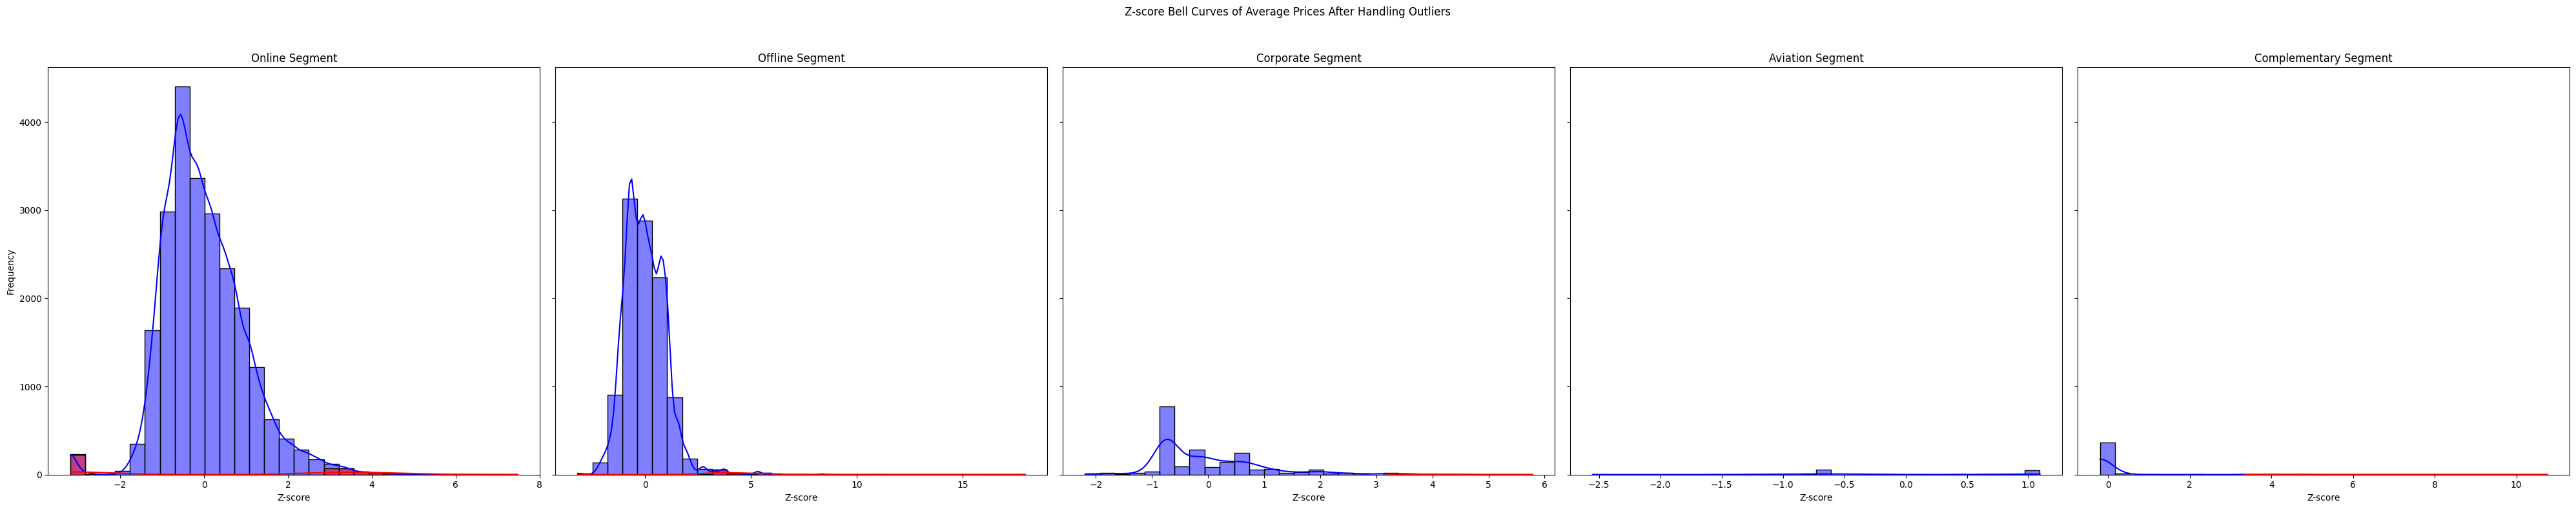

In [192]:
# Recalculate z-scores after handling outliers
cleaned_data['average_price_zscore'] = zscore(cleaned_data['average price'])

# Create subplots for z-score bell curves after handling outliers
fig, axes = plt.subplots(1, 5, figsize=(40, 8), sharey=True)

# Plot z-score bell curves for each segment after handling outliers
for i, segment in enumerate(segments):
    segment_data = cleaned_data[cleaned_data['market segment type'] == segment].copy()
    segment_data.loc[:, 'average_price_zscore'] = zscore(segment_data['average price'])

    sns.histplot(segment_data['average_price_zscore'], kde=True, color='blue', bins=30, ax=axes[i])

    # Highlight outliers
    outliers = segment_data[np.abs(segment_data['average_price_zscore']) > 3]
    sns.histplot(outliers['average_price_zscore'], kde=True, color='red', bins=30, ax=axes[i])

    axes[i].set_title(f'{segment} Segment')
    axes[i].set_xlabel('Z-score')
    axes[i].set_ylabel('Frequency')

plt.suptitle('Z-score Bell Curves of Average Prices After Handling Outliers')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

### Feature Engineering & Selection

In [193]:
cleaned_data.to_csv("first inten project_cleaned.csv", index=False)

In [194]:
cleaned_data.drop(columns=['Booking_ID'], inplace=True)

In [195]:
# Manual Encoding for Room Type
room_type_mapping = {'Room_Type 1': 1, 'Room_Type 2': 2, 'Room_Type 3': 3, 'Room_Type 4': 4, 'Room_Type 5': 5, 'Room_Type 6': 6,'Room_Type 7': 7}
cleaned_data['room type'] = cleaned_data['room type'].map(room_type_mapping)

In [196]:
# One-Hot Encoding for Market Segment and Meal Type
cleaned_data = pd.get_dummies(cleaned_data, columns=['market segment type'], prefix='Market')
cleaned_data = pd.get_dummies(cleaned_data, columns=['type of meal'], prefix='MealType')

In [197]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
cleaned_data['booking status'] = le.fit_transform(cleaned_data['booking status'])

In [198]:
cleaned_data['total nights'] = cleaned_data['number of weekend nights'] + cleaned_data['number of week nights']
cleaned_data['total_members'] = cleaned_data['number of adults'] + cleaned_data['number of children']
cleaned_data['percent_can'] = cleaned_data['Previously Canceled reservations'] / (cleaned_data['Previously Canceled reservations'] + cleaned_data['Previously Not Canceled reservations'] + 1e-10)
cleaned_data['is_weekend'] = (cleaned_data['number of weekend nights'] > 0).astype(int)

In [199]:
cleaned_data.head()

,number of adults,number of children,number of weekend nights,number of week nights,car parking space,room type,lead time,regular customer,Previously Canceled reservations,Previously Not Canceled reservations,...,Market_Offline,Market_Online,MealType_Meal Plan 1,MealType_Meal Plan 2,MealType_Meal Plan 3,MealType_Not Selected,total nights,total_members,percent_can,is_weekend
0,1,1,2,5,0,1,224.0,0,0,0,...,True,False,True,False,False,False,7,2,0.0,1
1,1,0,1,3,0,1,5.0,0,0,0,...,False,True,False,False,False,True,4,1,0.0,1
2,2,1,1,3,0,1,1.0,0,0,0,...,False,True,True,False,False,False,4,3,0.0,1
3,1,0,0,2,0,1,211.0,0,0,0,...,False,True,True,False,False,False,2,1,0.0,0
4,1,0,1,2,0,1,48.0,0,0,0,...,False,True,False,False,False,True,3,1,0.0,1


In [201]:
cleaned_data.drop(columns=['average_price_zscore'], inplace=True)

In [202]:
correlation_matrix = cleaned_data.corr()
correlation_with_booking_status = correlation_matrix['booking status'].abs().sort_values(ascending=False)
print(correlation_with_booking_status)

booking status                          1.000000
lead time                               0.352946
special requests                        0.253361
reservation_year                        0.179431
average price                           0.142584
Market_Corporate                        0.112760
regular customer                        0.107479
Market_Online                           0.106131
total nights                            0.103304
number of week nights                   0.092732
total_members                           0.089448
MealType_Meal Plan 2                    0.086647
number of adults                        0.086525
car parking space                       0.086047
Market_Complementary                    0.072827
number of weekend nights                0.061630
MealType_Meal Plan 1                    0.061287
Previously Not Canceled reservations    0.060041
is_weekend                              0.051477
percent_can                             0.041781
Market_Offline      

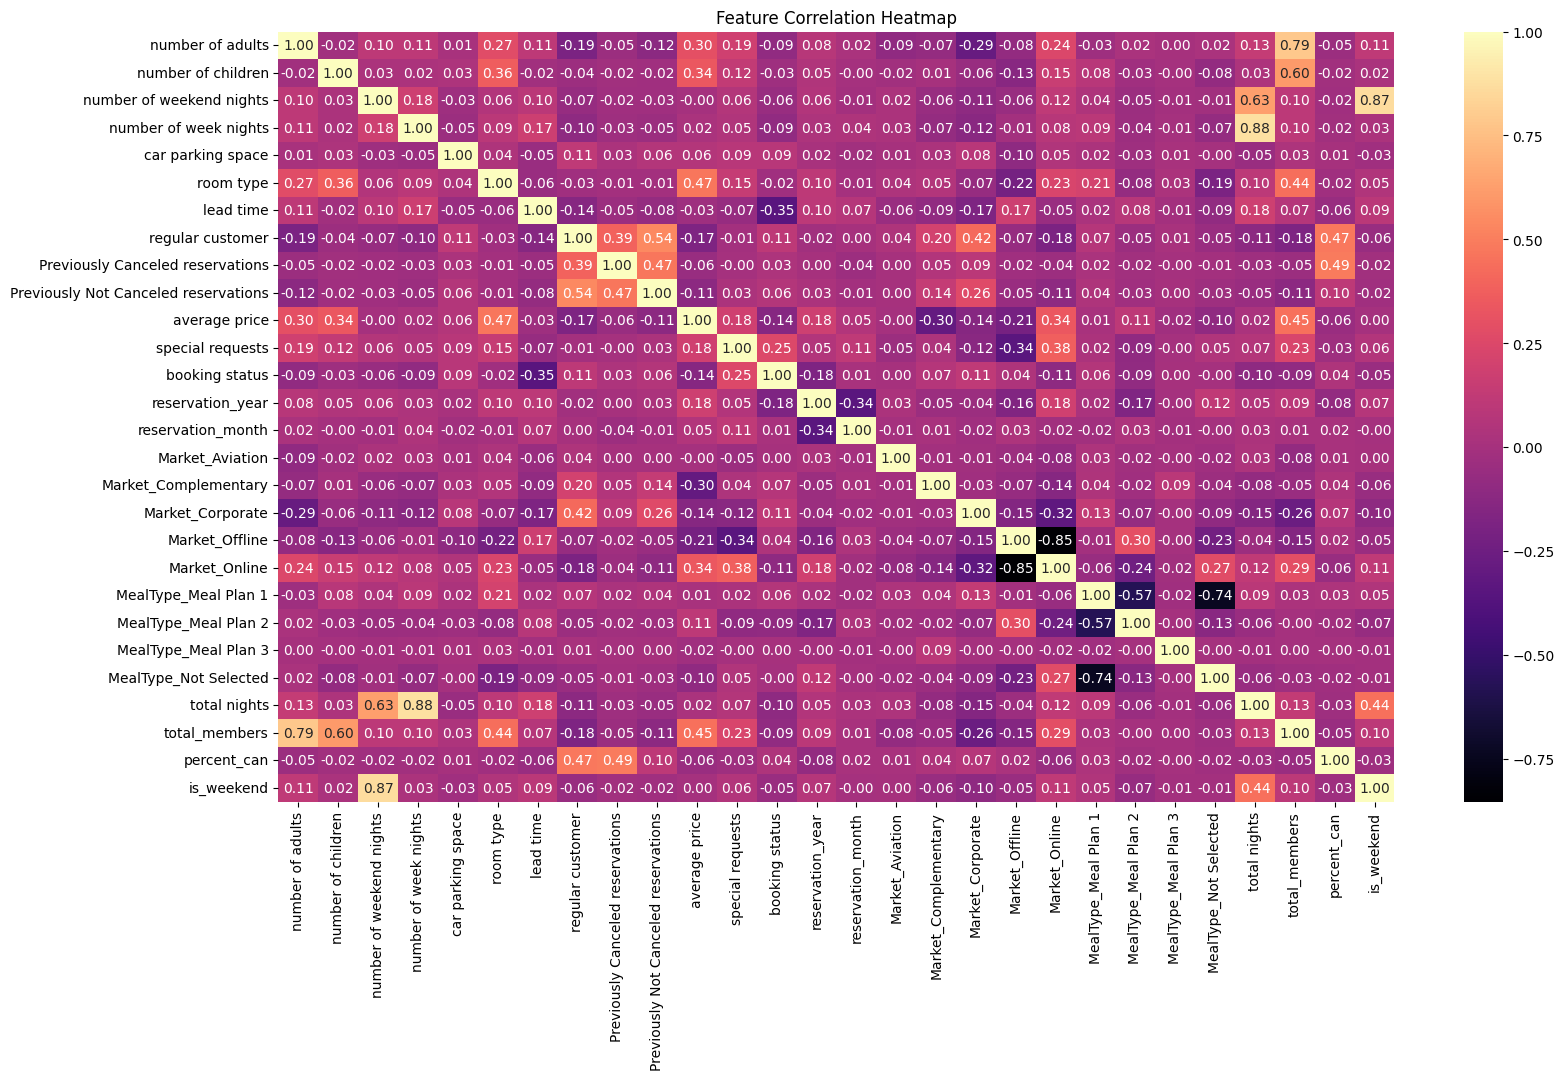

In [203]:
plt.figure(figsize=(18, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='magma', fmt=".2f")
plt.title('Feature Correlation Heatmap')
plt.show()

C:\Users\Habiba\AppData\Roaming\Python\Python313\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


                                 feature        VIF
0                       number of adults        inf
1                     number of children        inf
2               number of weekend nights        inf
3                  number of week nights        inf
4                      car parking space   1.068483
5                              room type   3.634061
6                              lead time   2.473072
7                       regular customer   2.066872
8       Previously Canceled reservations   1.749764
9   Previously Not Canceled reservations   1.867625
10                         average price  14.879812
11                      special requests   1.942295
12                        booking status   3.947173
13                      reservation_year  34.164058
14                     reservation_month   7.063440
15                          total nights        inf
16                         total_members        inf
17                           percent_can   1.781029
18          

C:\Users\Habiba\AppData\Local\Temp\ipykernel_20428\4141817843.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x="VIF", y="feature", data=vif_data, palette="magma")
C:\Users\Habiba\AppData\Roaming\Python\Python313\site-packages\matplotlib\transforms.py:351: RuntimeWarning: invalid value encountered in scalar subtract
  return points[1, 0] - points[0, 0]


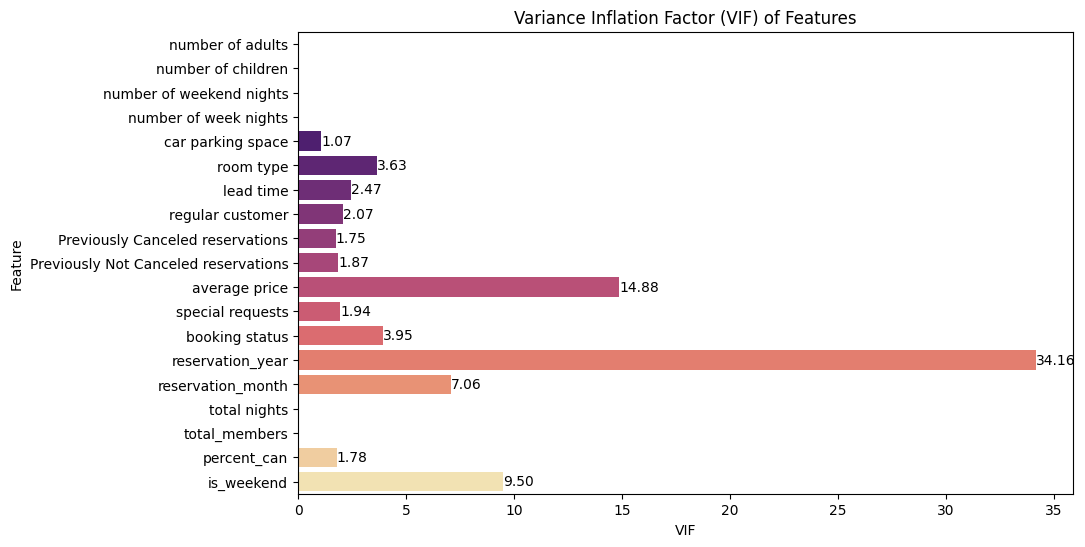

In [204]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Select only numeric columns
numeric_cols = cleaned_data.select_dtypes(include=[np.number]).columns

# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data["feature"] = numeric_cols
vif_data["VIF"] = [variance_inflation_factor(cleaned_data[numeric_cols].values, i) for i in range(len(numeric_cols))]

print(vif_data)
# Plot the VIF values
plt.figure(figsize=(10, 6))
barplot = sns.barplot(x="VIF", y="feature", data=vif_data, palette="magma")
plt.title("Variance Inflation Factor (VIF) of Features")
plt.xlabel("VIF")
plt.ylabel("Feature")

# Annotate the bars with the VIF values
for index, value in enumerate(vif_data["VIF"]):
    barplot.text(value, index, f'{value:.2f}', color='black', ha="left", va="center")

plt.show()

##### Remove features that have weak correlations with the target variable and those that could cause redundancy in the model to improve model efficiency and reduce noise in the data.

In [205]:
# Drop weak features (correlation ≈ 0) and features that cause redundancy
drop_columns = [
    'number of adults', 'number of children', 'number of weekend nights',
    'number of week nights', 'total nights', 'total_members',
    'reservation_year', 'average price', 'Market_Aviation',
    'MealType_Meal Plan 3', 'MealType_Not Selected',
    'Previously Canceled reservations', 'Previously Not Canceled reservations'
]

cleaned_data = cleaned_data.drop(columns=drop_columns)

# Print the remaining features
print("Remaining features:")
print(cleaned_data.columns)


Remaining features:
Index(['car parking space', 'room type', 'lead time', 'regular customer',
       'special requests', 'booking status', 'reservation_month',
       'Market_Complementary', 'Market_Corporate', 'Market_Offline',
       'Market_Online', 'MealType_Meal Plan 1', 'MealType_Meal Plan 2',
       'percent_can', 'is_weekend'],
      dtype='object')


# Target Variable Separation

##### Separate features (X) from target variable (y). Target variable is 'booking status'

In [206]:
X = cleaned_data.drop(columns=['booking status'], axis=1)
y = cleaned_data['booking status']

## Train-Test Split
split the data into training (80%) and testing (20%) sets.


In [207]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

## Class Distribution Check

In [208]:
# Check the data distribution in the training set
y_train.value_counts()

booking status
1    19493
0     9505
Name: count, dtype: int64

## Fix the imbalanced data using SMOTE

In [209]:
sm = SMOTE(random_state=42)
X_train, y_train = sm.fit_resample(X_train, y_train)

# Recheck the data balance
y_train.value_counts()

booking status
1    19493
0    19493
Name: count, dtype: int64

## Standardizes features to have zero mean and unit variance.

In [210]:
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [211]:
models = [
    ('KNN', KNeighborsClassifier(), {'n_neighbors': [3, 5, 7, 9]}),
    ('LogReg', LogisticRegression(), {'C': [0.1, 1, 10]}),
    ('RF', RandomForestClassifier(random_state=42), {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20]}),
    ('XGB', XGBClassifier(random_state=42), {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 0.5]}),
    ('SVM', SVC(kernel='linear', random_state=42), {'C': [0.1, 1, 10]})
]

In [ ]:
cv_results = {}
for name, model, param_grid in models:
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
    grid_search.fit(X_train_scaled, y_train)

    best_model = grid_search.best_estimator_
    cv_scores = cross_val_score(best_model, X_train_scaled, y_train, cv=5, scoring='f1')

    cv_results[name] = {
        'Best Hyperparameters': grid_search.best_params_,
        'Mean CV Score': cv_scores.mean(),
        'Std CV Score': cv_scores.std(),
        'CV Scores': cv_scores
    }

# Print results
for name, results in cv_results.items():
    print(f"\n{name} Results:")
    print(f"Best Hyperparameters: {results['Best Hyperparameters']}")
    print(f"CV Scores: {results['CV Scores']}")
    print(f"Mean CV Score: {results['Mean CV Score']:.4f} (+/- {results['Std CV Score']*2:.4f})")

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits

KNN Results:
Best Hyperparameters: {'n_neighbors': 3}
CV Scores: [0.83933146 0.84439445 0.86540199 0.87914692 0.88382567]
Mean CV Score: 0.8624 (+/- 0.0358)

LogReg Results:
Best Hyperparameters: {'C': 10}
CV Scores: [0.7490475  0.75787078 0.76723691 0.78413978 0.78405316]
Mean CV Score: 0.7685 (+/- 0.0280)

RF Results:
Best Hyperparameters: {'max_depth': 20, 'n_estimators': 200}
CV Scores: [0.8587853  0.86682566 0.88506043 0.89903909 0.90084611]
Mean CV Score: 0.8821 (+/- 0.0338)

XGB Results:
Best Hyperparameters: {'learning_rate': 0.5, 'n_estimators': 200}
CV Scores: [0.85254961 0.8637052  0.88150552 0.89576417 0.89772576]
Mean CV Score: 0.8783 (+/- 0.0354)

SVM Results:
Best Hyperparame

# KNN Model

#### Implement the elbow method to find the optimal number of neighbors (k) for our KNN model by plotting error rates against different k values.

The optimal k value is: 1


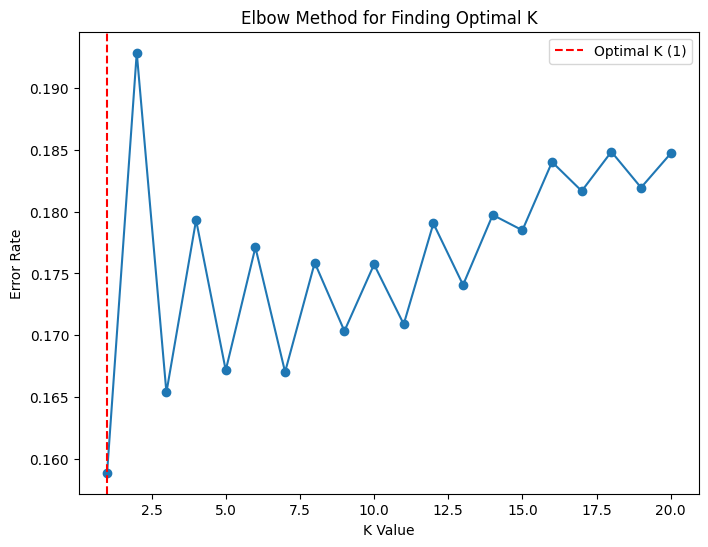

In [212]:
# Find the optimal k value using the elbow method
k_values = range(1, 21)
error_rates = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_scaled, y_train)
    y_pred = knn.predict(X_test_scaled)
    error_rate = 1 - accuracy_score(y_test, y_pred)
    error_rates.append(error_rate)

# Find the optimal k value
optimal_k = k_values[error_rates.index(min(error_rates))]
print(f"The optimal k value is: {optimal_k}")

plt.figure(figsize=(8, 6))
plt.plot(k_values, error_rates, marker='o')
plt.xlabel('K Value')
plt.ylabel('Error Rate')
plt.title('Elbow Method for Finding Optimal K')
plt.axvline(x=optimal_k, linestyle='--', color='red', label=f"Optimal K ({optimal_k})")
plt.legend()
plt.show()

## Model Creation.

In [213]:
knn = KNeighborsClassifier(n_neighbors=1)

## Model Training.

In [214]:
knn.fit(X_train_scaled, y_train)

KNeighborsClassifier(n_neighbors=1)

## Make Predictions.
Use the trained model to make predictions on test set

In [215]:
knn_pred = knn.predict(X_test_scaled)

In [ ]:
knn_accuracy = accuracy_score(y_test, knn_pred)
print(f"KNN Accuracy: {knn_accuracy:.3f}\n")

knn_report = classification_report(y_test, knn_pred)
print("Classification Report:\n", knn_report)

KNN Accuracy: 0.844

Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.79      0.77      2377
           1       0.89      0.87      0.88      4873

    accuracy                           0.84      7250
   macro avg       0.82      0.83      0.82      7250
weighted avg       0.85      0.84      0.84      7250



In [216]:
knn_precision = precision_score(y_test, knn_pred, average="weighted")
knn_recall = recall_score(y_test, knn_pred, average="weighted")
knn_f1 = f1_score(y_test, knn_pred, average="weighted")

In [217]:
# Create Confusion Matrix
cm = confusion_matrix(y_test, knn_pred)

# Create Classification Report
report_dict = classification_report(y_test, knn_pred, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()
metrics_to_plot = ["precision", "recall", "f1-score"]
report_df = report_df[metrics_to_plot]


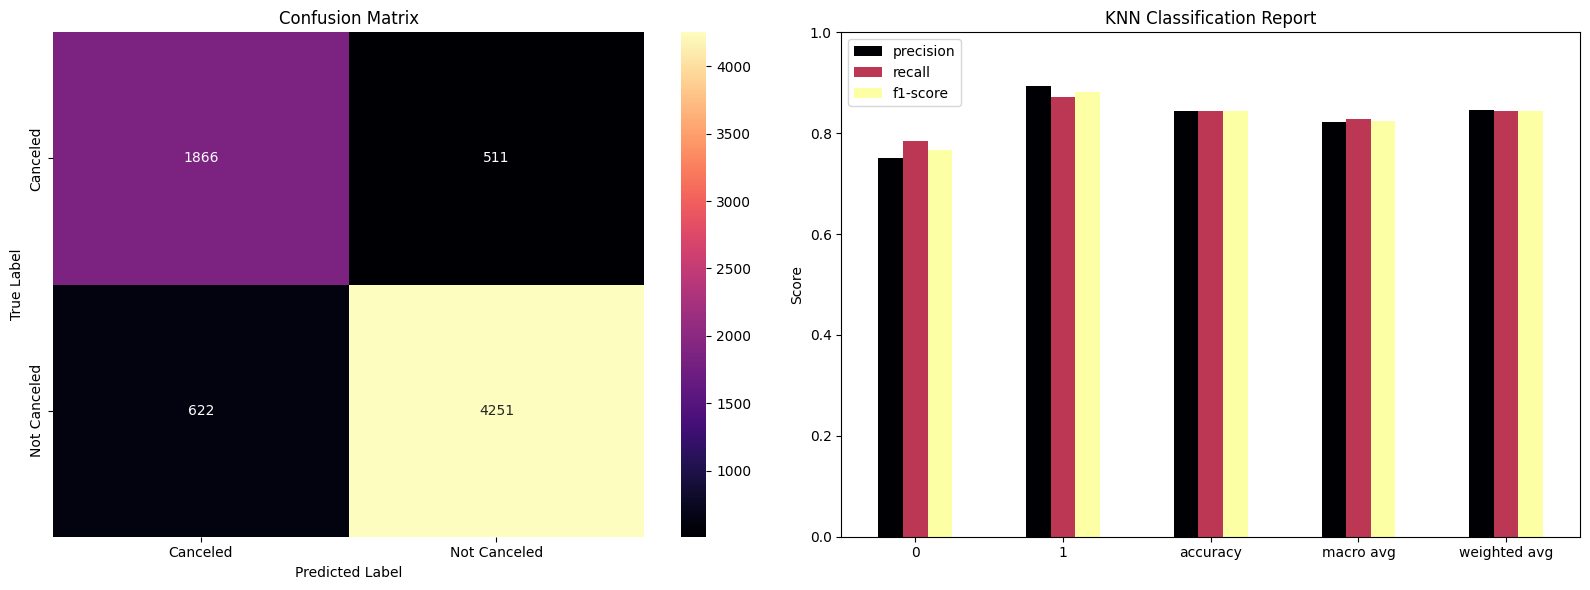

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

sns.heatmap(cm, annot=True, fmt='d', cmap='magma', cbar=True, ax=axes[0],
            xticklabels=['Canceled', 'Not Canceled'], yticklabels=['Canceled', 'Not Canceled'])
axes[0].set_title("Confusion Matrix")
axes[0].set_xlabel("Predicted Label")
axes[0].set_ylabel("True Label")


report_df.plot(kind='bar', ax=axes[1], colormap='inferno', rot=0)
axes[1].set_title("KNN Classification Report")
axes[1].set_ylim(0, 1)
axes[1].legend(loc='upper left')
axes[1].set_ylabel("Score")

plt.tight_layout()
plt.show()

# Logistic Regression Model

In [218]:
logistic = LogisticRegression(C=10)

### Cross-Validation Evaluation.

**What it does:**
- Splits training data into 5 parts
- Trains and validates model 5 times using different parts each time  
- Takes average of all 5 scores to get final accuracy

**Why it's important:**
- More reliable than single train-test split
- Helps detect if model is overfitting
- Shows how model performs across different subsets of data

**Visual Example:**
```
Data:  [Fold 1] [Fold 2] [Fold 3] [Fold 4] [Fold 5]

Round 1: [Test]  [Train] [Train] [Train] [Train]
Round 2: [Train] [Test]  [Train] [Train] [Train]
Round 3: [Train] [Train] [Test]  [Train] [Train]
Round 4: [Train] [Train] [Train] [Test]  [Train]
Round 5: [Train] [Train] [Train] [Train] [Test]
```

Final score = Average of all 5 rounds
```

In [219]:
cv_scores = cross_val_score(logistic, X_train_scaled, y_train, cv=5, scoring='accuracy')
print(f'Mean Accuracy: {cv_scores.mean()}')

Mean Accuracy: 0.7385220073496811


In [220]:
logistic.fit(X_train_scaled, y_train)


LogisticRegression(C=10)

In [221]:
logistic_pred = logistic.predict(X_test_scaled)

In [ ]:
logistic_accuracy = accuracy_score(y_test, logistic_pred)
print(f"Logistic Accuracy: {logistic_accuracy:.3f}\n")
logistic_report = classification_report(y_test, logistic_pred)
print("Classification Report:\n", logistic_report)

Logistic Accuracy: 0.759

Classification Report:
               precision    recall  f1-score   support

           0       0.62      0.70      0.65      2377
           1       0.84      0.79      0.81      4873

    accuracy                           0.76      7250
   macro avg       0.73      0.74      0.73      7250
weighted avg       0.77      0.76      0.76      7250



In [ ]:
logistic_precision = precision_score(y_test, logistic_pred, average="weighted")
logistic_recall = recall_score(y_test, logistic_pred, average="weighted")
logistic_f1 = f1_score(y_test, logistic_pred, average="weighted")

In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_test, logistic_pred)

# Classification Report
report_dict = classification_report(y_test, logistic_pred, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()
metrics_to_plot = ["precision", "recall", "f1-score"]
report_df = report_df[metrics_to_plot]

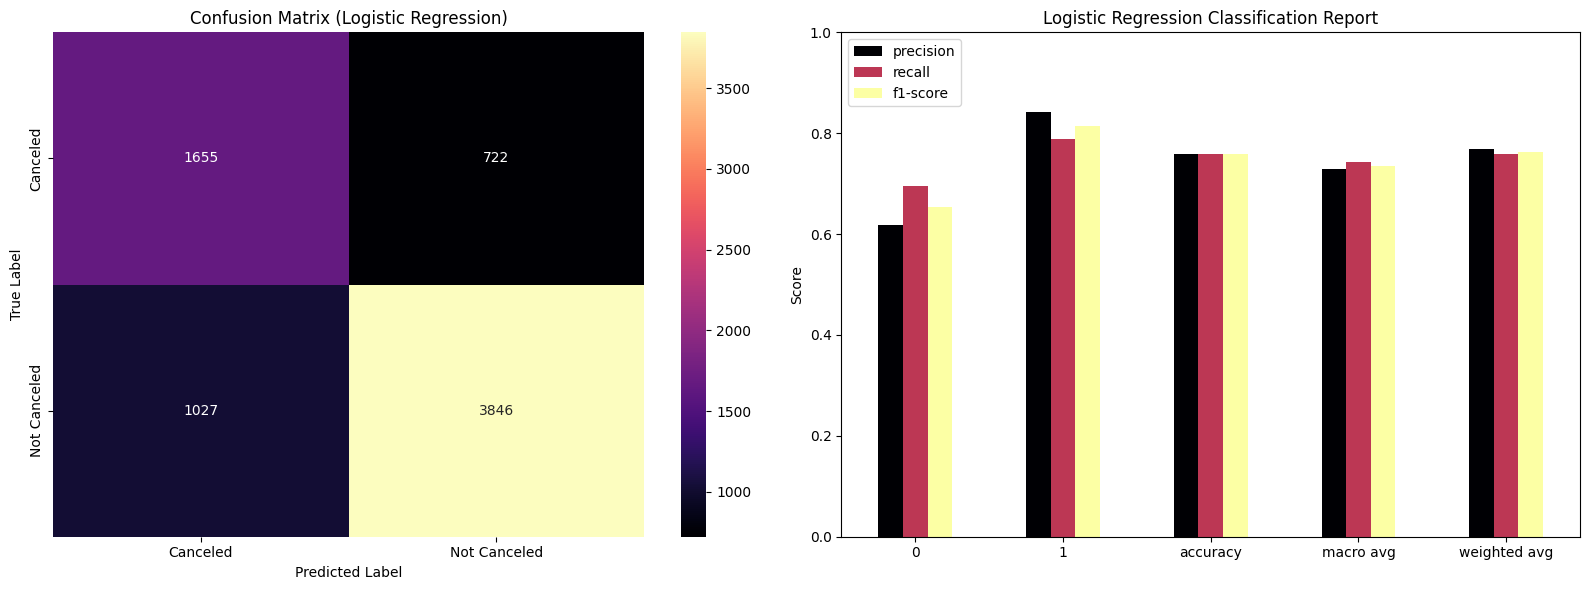

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

sns.heatmap(cm, annot=True, fmt='d', cmap='magma', cbar=True, ax=axes[0],
            xticklabels=['Canceled', 'Not Canceled'], yticklabels=['Canceled', 'Not Canceled'])
axes[0].set_title("Confusion Matrix (Logistic Regression)")
axes[0].set_xlabel("Predicted Label")
axes[0].set_ylabel("True Label")


report_df.plot(kind='bar', ax=axes[1], colormap='inferno', rot=0)
axes[1].set_title("Logistic Regression Classification Report")
axes[1].set_ylim(0, 1)
axes[1].legend(loc='upper left')
axes[1].set_ylabel("Score")

plt.tight_layout()
plt.show()

# XGBoost Model

In [222]:
xgb_model = XGBClassifier(learning_rate = 0.4, n_estimators = 200)

In [223]:
xgb_model.fit(X_train_scaled, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.4, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [224]:
xgb_pred = xgb_model.predict(X_test_scaled)

In [ ]:
xgb_accuracy = accuracy_score(y_test, xgb_pred)
print(f"XGB Accuracy: {xgb_accuracy:.3f}\n")
xgb_report = classification_report(y_test, xgb_pred)
print("Classification Report:\n", xgb_report)

XGB Accuracy: 0.887

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.82      0.83      2377
           1       0.91      0.92      0.92      4873

    accuracy                           0.89      7250
   macro avg       0.87      0.87      0.87      7250
weighted avg       0.89      0.89      0.89      7250



In [ ]:
xgb_precision = precision_score(y_test, xgb_pred, average="weighted")
xgb_recall = recall_score(y_test, xgb_pred, average="weighted")
xgb_f1 = f1_score(y_test, xgb_pred, average="weighted")

In [ ]:
xgb_probs = xgb_model.predict_proba(X_test_scaled)[:, 1]

# Compute Performance Metrics
xgb_cm = confusion_matrix(y_test, xgb_pred)
xgb_report_dict = classification_report(y_test, xgb_pred, output_dict=True)
xgb_report_df = pd.DataFrame(xgb_report_dict).transpose()[["precision", "recall", "f1-score"]]

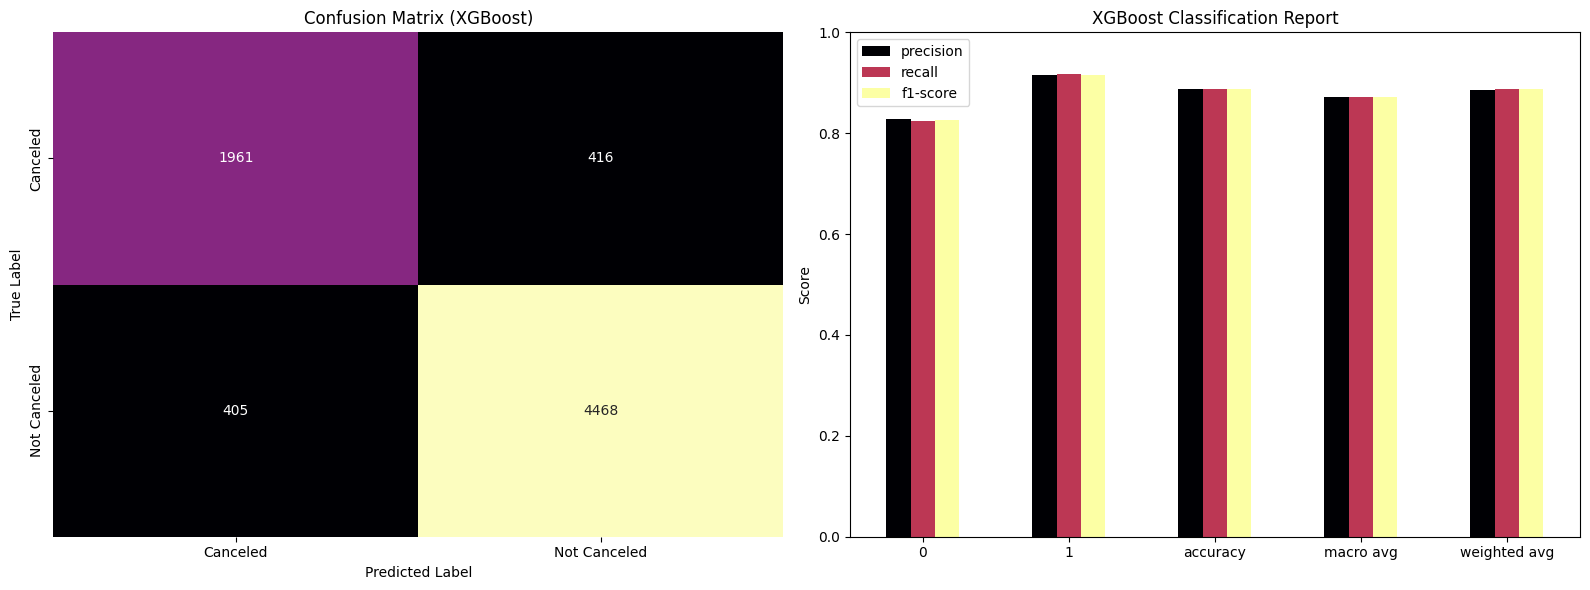

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.heatmap(xgb_cm, annot=True, fmt='d', cmap='magma', cbar=False, ax=axes[0],
            xticklabels=['Canceled', 'Not Canceled'], yticklabels=['Canceled', 'Not Canceled'])
axes[0].set_title("Confusion Matrix (XGBoost)")
axes[0].set_xlabel("Predicted Label")
axes[0].set_ylabel("True Label")


xgb_report_df.plot(kind='bar', ax=axes[1], colormap='inferno', rot=0)
axes[1].set_title("XGBoost Classification Report")
axes[1].set_ylim(0, 1)
axes[1].legend(loc='upper left')
axes[1].set_ylabel("Score")

plt.tight_layout()
plt.show()

# Random Forest Model

In [225]:
rf_model = RandomForestClassifier(max_depth = 20, n_estimators = 150)

In [226]:
rf_model.fit(X_train_scaled, y_train)

RandomForestClassifier(max_depth=20, n_estimators=150)

In [227]:
rf_pred = rf_model.predict(X_test_scaled)

In [ ]:
rf_accuracy = accuracy_score(y_test, rf_pred)
print(f"RF Accuracy: {rf_accuracy:.3f}\n")
rf_report = classification_report(y_test, rf_pred)
print("Classification Report:\n", rf_report)

RF Accuracy: 0.887

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.82      0.83      2377
           1       0.91      0.92      0.92      4873

    accuracy                           0.89      7250
   macro avg       0.87      0.87      0.87      7250
weighted avg       0.89      0.89      0.89      7250



In [ ]:
rf_precision = precision_score(y_test, rf_pred, average="weighted")
rf_recall = recall_score(y_test, rf_pred, average="weighted")
rf_f1 = f1_score(y_test, rf_pred, average="weighted")

In [ ]:
rf_probs = rf_model.predict_proba(X_test_scaled)[:, 1]

# Compute Performance Metrics
rf_cm = confusion_matrix(y_test, rf_pred)
rf_report_dict = classification_report(y_test, rf_pred, output_dict=True)
rf_report_df = pd.DataFrame(rf_report_dict).transpose()[["precision", "recall", "f1-score"]]

Text(839.0858585858584, 0.5, 'Score')

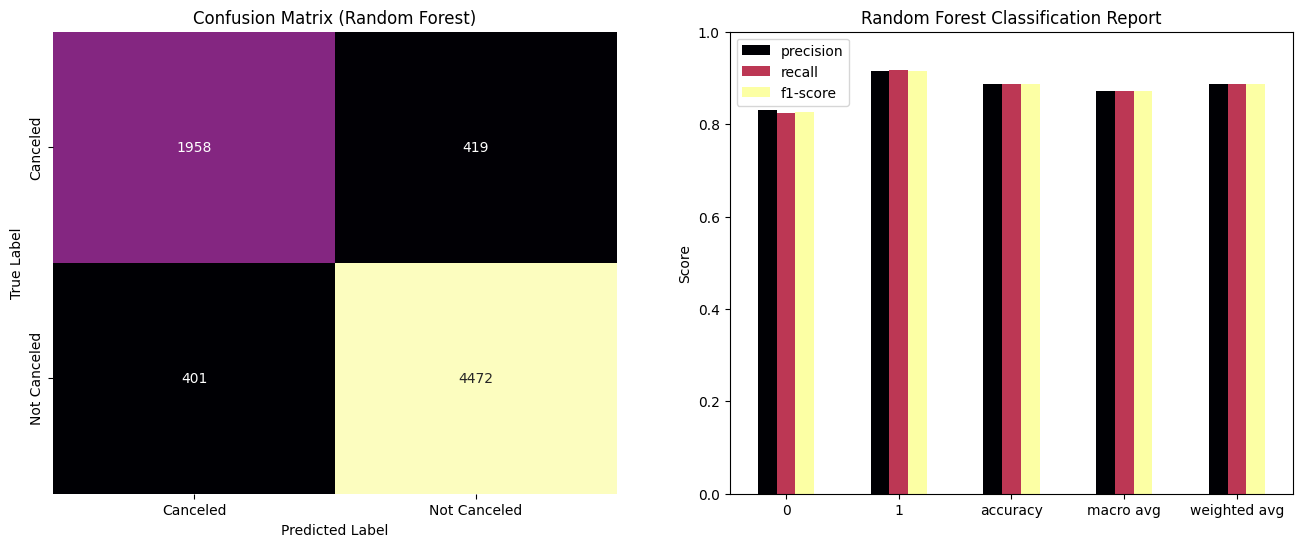

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.heatmap(rf_cm, annot=True, fmt='d', cmap='magma', cbar=False, ax=axes[0],
            xticklabels=['Canceled', 'Not Canceled'], yticklabels=['Canceled', 'Not Canceled'])
axes[0].set_title("Confusion Matrix (Random Forest)")
axes[0].set_xlabel("Predicted Label")
axes[0].set_ylabel("True Label")


rf_report_df.plot(kind='bar', ax=axes[1], colormap='inferno', rot=0)
axes[1].set_title("Random Forest Classification Report")
axes[1].set_ylim(0, 1)
axes[1].legend(loc='upper left')
axes[1].set_ylabel("Score")

In [ ]:
# Create a DataFrame to store all model metrics
models = ['KNN', 'Logistic Regression', 'Random Forest', 'XGBoost']
accuracies = [knn_accuracy, logistic_accuracy, rf_accuracy, xgb_accuracy]
precisions = [knn_precision, logistic_precision, rf_precision, xgb_precision]
recalls = [knn_recall, logistic_recall, rf_recall, xgb_recall]
f1_scores = [knn_f1, logistic_f1, rf_f1, xgb_f1]

metrics_df = pd.DataFrame({
    'Model': models,
    'Accuracy': accuracies,
    'Precision': precisions,
    'Recall': recalls,
    'F1 Score': f1_scores
})

# Display the metrics DataFrame
metrics_df = metrics_df.sort_values(by='F1 Score', ascending=False)

metrics_df.head()

,Model,Accuracy,Precision,Recall,F1 Score
2,Random Forest,0.886897,0.886687,0.886897,0.886786
3,XGBoost,0.886759,0.886628,0.886759,0.886691
0,KNN,0.843724,0.845909,0.843724,0.844607
1,Logistic Regression,0.758759,0.768219,0.758759,0.762134


In [228]:
joblib.dump(rf_model, 'random_forest_model.pkl')

['random_forest_model.pkl']